<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CervejaGratis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For the Next

* Oraganizar o código 

1. Extrutura dos dados
2. É possível fixar um valor máximo e ou mínimo para a saída da série?

* Implementar uma RNN, LSTM e GRU, com os erros tradicionais e avalaiar desempenho

* Implementar um MLP (caso mais simples) 

* Implmentar uma LSTM Bidirecional para clasificação ???


----







# Librarys

In [1]:
#!pip install colorednoise
import colorednoise as cn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import seaborn as sns
from matplotlib.gridspec import GridSpec
#np.random.seed(42)
sns.set_style('darkgrid')
%matplotlib inline


# Functions

In [2]:
def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    data_train_X.append(dataset_train[i:(i+window_in), 0])
    data_train_Y.append(dataset_train[i + window_in:i + window_in + window_ou, 0])

    data_test_X.append(dataset_test[i:(i+window_in), 0])
    data_test_Y.append(dataset_test[i + window_in:i + window_in + window_ou, 0])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def create_dataset2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  trainX, trainY = norm3(rn2)
  trainX, trainY = torch.tensor(trainX), torch.tensor(trainY)



  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm3(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm3(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)



def plot_test(x_,y_):
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_,label='Input')
  plt.plot(y2,label='Target')    

def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

def kurtosis(t, fisher=True):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

def param(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def param_2(data):
  #data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    
#param_2(torch.tensor([wn2,rn2]))  


def norm(data):
  '''
  Normalize the dataframe from -1 to 1
  '''
  scaler = MaxAbsScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2

def norm2(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MaxAbsScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = (scaler.fit_transform(data1)+1)/2 #Esta célula contem a diferença
  data2 = np.reshape(data1,len(data1))
  return data1, data2

def norm3(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  #data1 = data-np.min(data)
  #data1 = data1/np.max(data1)
  data1 = scaler.fit_transform(data1) #Esta célula contem a diferença
  data2 = np.reshape(data1,len(data1))
  return data1, data2  

def norm4(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  #data1 = data-np.min(data)
  #data1 = data1/np.max(data1)
  data1 = scaler.fit_transform(data1) #Esta célula contem a diferença
  data2 = np.reshape(data1,len(data1))
  return data2  

## Calculo do Beta


A biblioteca pytorch possui as funções de transformada rápida de fourier (fft),respectivo conjunto de frequência (fftfreq) e logarítmo implementada já a nível vetorizado.

No entanto, foi necessário implementar manualmente o ajuste linear para medir o beta, uma boa referência (com o método dos minimos quadrados) é:

http://195.134.76.37/applets/AppletPoly/Appl_Poly2.html

In [3]:
class DBeta(nn.Module):
  def __init__(self):
    super(DBeta, self).__init__();

  def beta(self,vet):
    ft = torch.fft.fft(vet,dim =1)
    ft = ft*torch.conj(ft)
    psd = torch.real(ft)
    freq = torch.fft.fftfreq(vet.size(dim=1))
    freq = freq.repeat(psd.size(dim=0),1)

    # remove frequencias negativas e zero
    freq = freq[:,1:vet.size(dim=1)//2]
    psd = psd[:,1:vet.size(dim=1)//2]

    #passa para escala log
    #print(freq.size())
    freq = torch.log(freq)
    psd = torch.log(psd)
    
    #print(psd.size(dim=0))

    # calcula o angulo do ajuste linear
    b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
    #print(vet.size(), b.size())
    
    return b
    
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    #print(predictions.size(),target.size())
    #print(self.beta(predictions), self.beta(target), square_difference)
    #print(torch.mean(square_difference))
    return torch.mean(square_difference)

## Calculo do beta sigma

In [4]:
class DBeta_sigma(nn.Module):
  def __init__(self):
    super(DBeta_sigma, self).__init__();

  def beta(self,vet):
    ft = torch.fft.fft(vet,dim =1)
    ft = ft*torch.conj(ft)
    psd = torch.real(ft)
    freq = torch.fft.fftfreq(vet.size(dim=1))
    freq = freq.repeat(psd.size(dim=0),1)

    # remove frequencias negativas e zero
    freq = freq[:,1:vet.size(dim=1)//2]
    psd = psd[:,1:vet.size(dim=1)//2]

    #passa para escala log
    #print(freq.size())
    freq = torch.log(freq)
    psd = torch.log(psd)
    
    #print(psd.size(dim=0))

    # calcula o angulo do ajuste linear
    b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
    #print(vet.size(), b.size())
    
    return b
  '''
  ##############################
  '''
  def skew(self,t):
      """
      Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
      :param t: a :class:`Tensor`
      :return: a scalar
      """
      return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

  def kurtosis(self,t, fisher=True):
      """
      Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
      :param t: a :class:`Tensor`
      :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
      :return: a scalar
      """
      return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

  def param(self,data):
    data = torch.tensor(data)
    return self.kurtosis(data)+ torch.mean(data,dim=1)+self.skew(data)+torch.std(data,dim=1)

  '''
  ############################################################################
  '''

  def forward(self, predictions, target):
    square_difference = torch.mean(torch.square(self.beta(predictions) - self.beta(target)))
    sq2 = torch.mean(torch.square(predictions-target))
    return square_difference + sq2
  
  def __call__(self, predictions, target):
    return self.forward(predictions, target)

# Data

## Data 1: - Simple $\sin(x)$ data 
https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

In [5]:
# N = 100 # number of samples
# L = 1000 # length of each sample (number of values for each sine wave)
# T = 20 # width of the wave
# x = np.empty((N,L), np.float32) # instantiate empty array
# x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
# y = np.sin(x/1.0/T).astype(np.float32)

# plt.figure(figsize=(20,10))
# for k in range(9):
#   plt.subplot(3,3,k+1)
#   plt.plot(x[0+k],y[0+k], marker='+',label="Batch 0")
#   plt.plot(x[50+k],y[50+k],label="Batch 50")
#   plt.legend()
# plt.show()

## Data 2: Combined $w_1 \sin(x) + w_2 \sin(x)$

Combined $w_1 \sin(x+\theta_1) + w_2 \sin(x+\theta_2) + Noise()$

https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [6]:
# def generate_time_series(batch_size, n_steps,w1=0.5,w2=0,w3=0,var_freq=True):
#     offsets1, offsets2 = np.random.rand(2, batch_size, 1)
#     if var_freq == True:
#       freq1, freq2 = np.random.rand(2, batch_size, 1)
#     else:
#       freq1, freq2 = np.empty((batch_size,n_steps), np.float32), np.empty((batch_size,n_steps), np.float32), 
#       freq1[:], freq2[:] = 0.5,0.5
#     time = np.linspace(0, 1, n_steps)
#     series = w1 * np.sin((time - offsets1)  * (freq1 * 100 + 10))  #   wave 1
#     series += w2 * np.sin((time - offsets2) * (freq2 * 200 + 20)) # + wave 2
#     series += w3 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
#     return series#[..., np.newaxis].astype(np.float32)

# N = 100 # number of samples
# L = 1000 # length of each sample (number of values for each sine wave)

# y = generate_time_series(N,L,0.5,0.2,0.000,var_freq=False)
# plt.figure(figsize=(20,10))
# for i in range(9):
#   plt.subplot(3,3,i+1)
#   plt.plot(y[i])
# plt.show()


## Data 3: Colored Noise

In [7]:
delta_beta = DBeta()

a = cn.powerlaw_psd_gaussian(2, 2**16)

a1 = a[:2**15]
a2 = a[2*15:2**16]

a = torch.tensor(np.array([a]))
a1 = torch.tensor(np.array([a1]))
a2 = torch.tensor(np.array([a2]))

print(delta_beta.beta(a))
print(delta_beta.beta(a1))
print(delta_beta.beta(a2))
print(delta_beta.beta(a1)-delta_beta.beta(a2))
print(nn.MSELoss())

tensor([-1.9855], dtype=torch.float64)
tensor([-1.9829], dtype=torch.float64)
tensor([-1.9940], dtype=torch.float64)
tensor([0.0111], dtype=torch.float64)
MSELoss()


In [9]:
samples = 2**20

wn = cn.powerlaw_psd_gaussian(0, samples)
pn = cn.powerlaw_psd_gaussian(1, samples)
rn = cn.powerlaw_psd_gaussian(2, samples)

wn1,wn2 = norm2(wn)
pn1,pn2 = norm2(pn)
rn1,rn2 = norm2(rn)  

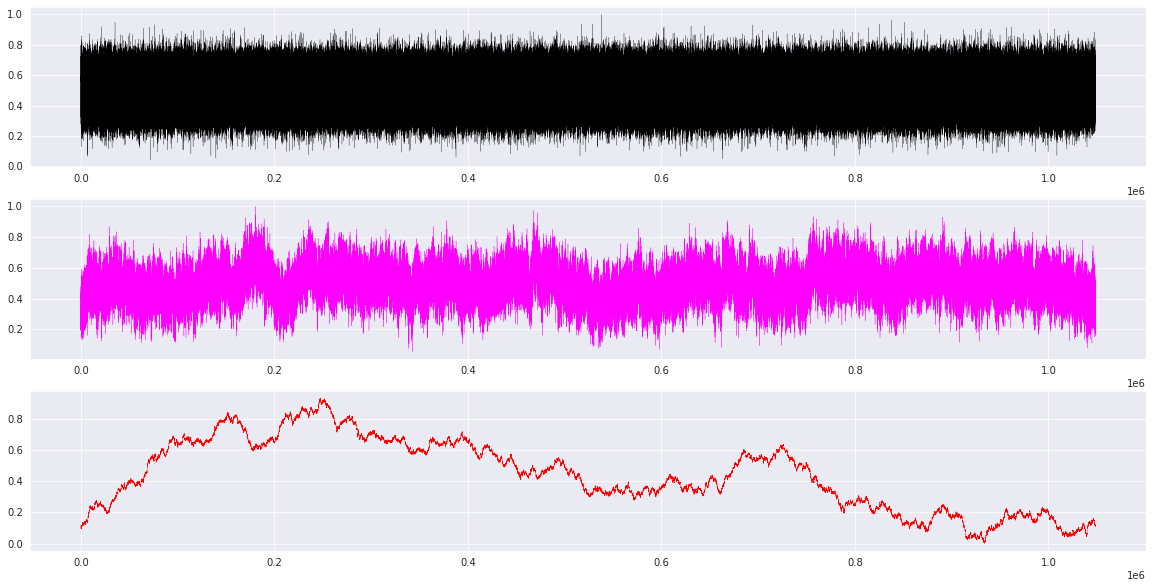

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(wn2,color='black',alpha=1,linewidth=0.2)
plt.subplot(3,1,2)
plt.plot(pn2,color='magenta',alpha=1,linewidth=0.3)
plt.subplot(3,1,3)
plt.plot(rn2,color='red',linewidth=0.3)

plt.show()

# Creating `trainX` and `trainY`

In [11]:
win_in = 1024
win_ou = 1024
jump = 512

dataset = rn
trainX, trainY, trainX_test,trainY_test = create_dataset2(dataset,win_in,win_ou,jump,isTensor=True)
#trainX, trainY, trainX_test, trainY_test = torch.tensor(trainX), torch.tensor(trainY), torch.tensor(trainX_test), torch.tensor(trainY_test)

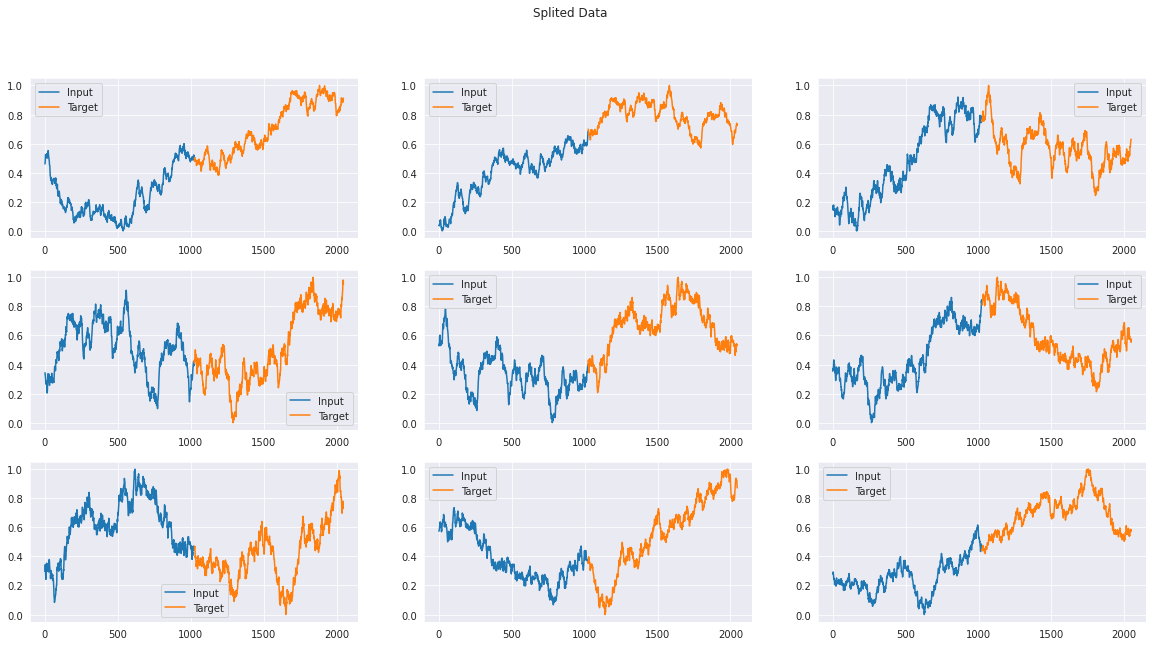

In [12]:
plt.figure(figsize=(20,10))
plt.suptitle('Splited Data')
for k in range(9):
  plt.subplot(3,3,k+1)
  plot_test(trainX[k],trainY[k])
  plt.legend()
plt.show()

# Data Analyse

In [13]:
def dataset_test(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  data_train_X, data_train_Y = [], []
  for i in range(0,len(dataset)-window_in-window_ou+1,strid):
    data_train_X.append(norm4(dataset[i:(i+window_in)]))
    data_train_Y.append(norm4(dataset[i + window_in:i + window_in + window_ou]))
  # data_train_X = norm3(data_trainX)
  # data_train_Y = norm3(data_trainY) 
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

In [14]:
win_in = 1024
win_ou = 1024
jump   = 512

#Data Set 01 - Recorted dataset

trainX_wn_01, trainY_wn_01 = dataset_test(wn,win_in,win_ou,jump,isTensor=True)
trainX_pn_01, trainY_pn_01 = dataset_test(pn,win_in,win_ou,jump,isTensor=True)
trainX_rn_01, trainY_rn_01 = dataset_test(rn,win_in,win_ou,jump,isTensor=True)

In [16]:
#Data Set 02 - Generated All Single Series

trainX_wn_02,trainX_pn_02,trainX_rn_02 = [],[],[]
trainY_wn_02,trainY_pn_02,trainY_rn_02 = [],[],[]
for i in range(len(trainX_wn_01)):
  trainX_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_in)))
  trainY_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_ou)))
  trainX_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_in)))
  trainY_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_ou)))
  trainX_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_in)))
  trainY_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_ou)))

trainX_wn_02, trainY_wn_02= torch.tensor(trainX_wn_02), torch.tensor(trainY_wn_02)
trainX_pn_02, trainY_pn_02= torch.tensor(trainX_pn_02), torch.tensor(trainY_pn_02)
trainX_rn_02, trainY_rn_02= torch.tensor(trainX_rn_02), torch.tensor(trainY_rn_02)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


In [ ]:
# #Data Set 03 - TrainX and TrainY from a single Series

# def dataset_test2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
#   data_train_X, data_train_Y = [], []
#   for i in range(0,len(dataset)-window_in-window_ou+1,strid):
#     data_train_X.append(dataset[:len(dataset)//2])
#     data_train_Y.append(dataset[len(dataset)//2:])
#   if isTensor:
#     return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
#   else:
#     return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

# train_wn,train_pn,train_rn = [],[],[]

# for i in range(len(trainX_wn_01)):
#   train_wn.append(norm4(cn.powerlaw_psd_gaussian(0, win_in+win_ou)))
#   train_pn.append(norm4(cn.powerlaw_psd_gaussian(1, win_in+win_ou)))
#   train_rn.append(norm4(cn.powerlaw_psd_gaussian(2, win_in+win_ou)))

# trainX_wn_03, trainY_wn_03 = dataset_test2(train_wn)
# trainX_pn_03, trainY_pn_03 = dataset_test2(train_pn)
# trainX_rn_03, trainY_rn_03 = dataset_test2(train_rn)

 

In [ ]:
print(len(trainX_wn))
print(len(trainX_gen_wn))

2045
2045


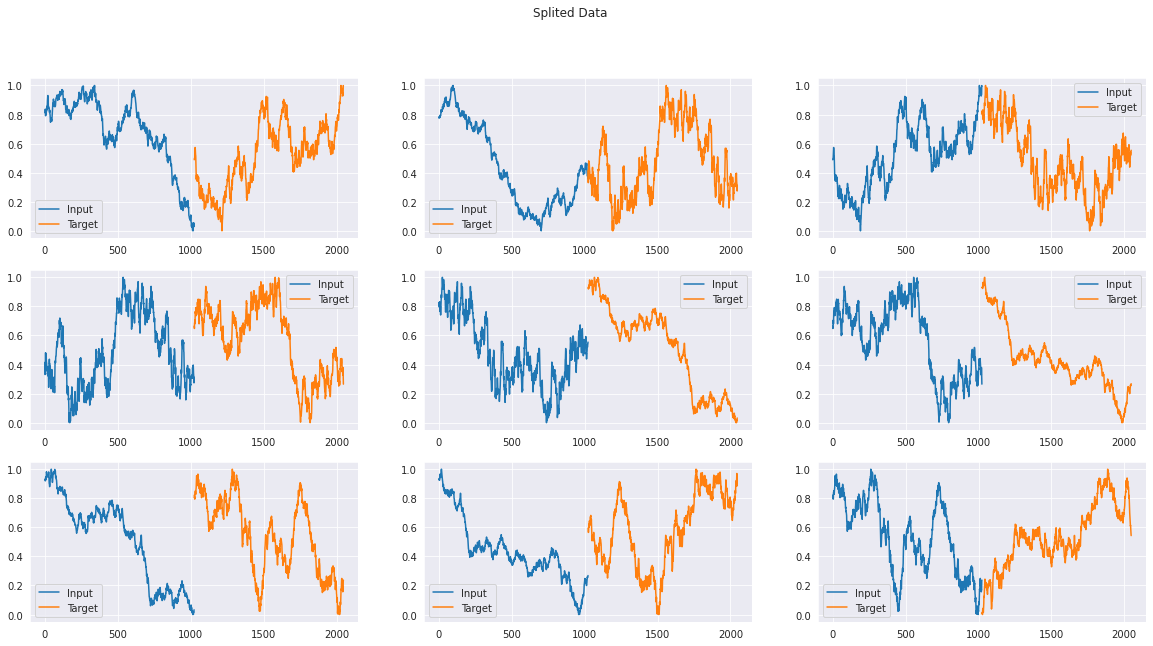

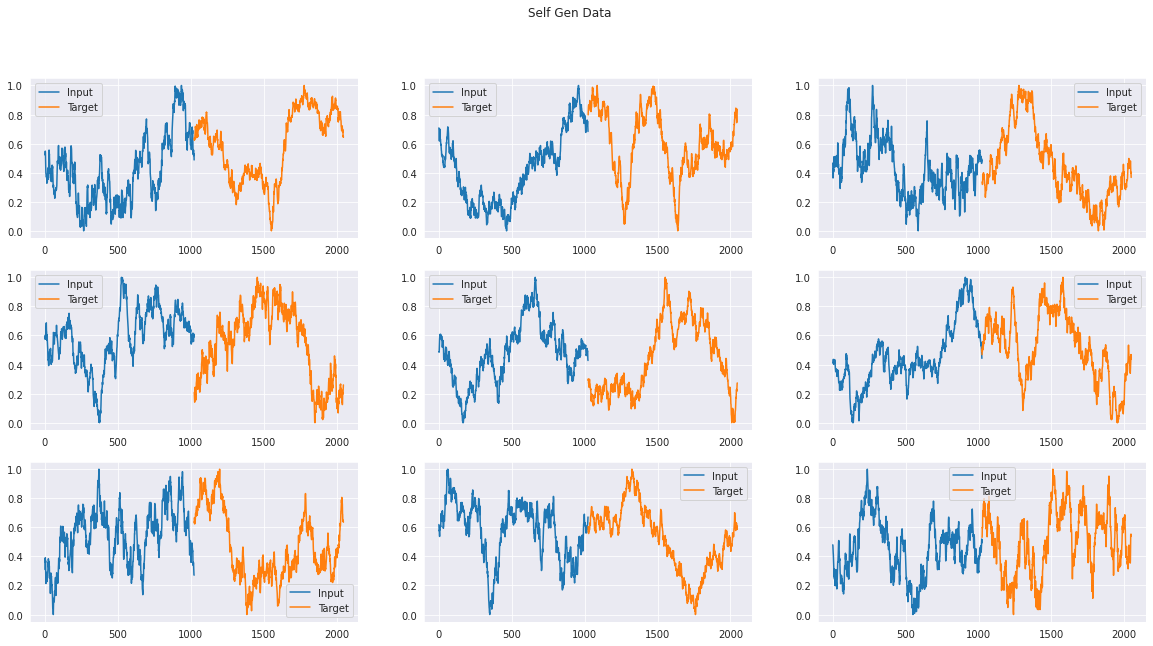

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle('Splited Data')
for k in range(9):
  plt.subplot(3,3,k+1)
  plot_test(trainX_rn[k],trainY_rn[k])
  plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.suptitle('Self Gen Data')
for k in range(9):
  plt.subplot(3,3,k+1)
  plot_test(trainX_gen_rn[k],trainY_gen_rn[k])
  plt.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be

<Figure size 1800x720 with 0 Axes>

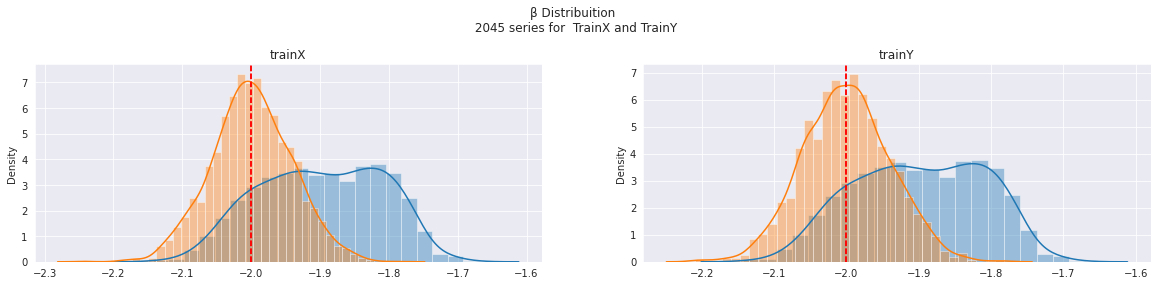

In [ ]:
beta_index = -2
delta_beta = DBeta()
def dist_plot(trainX,trainY,trainX_gen,trainY_gen,beta_index=0):  
  plt.figure(figsize=(20,8))
  plt.suptitle(f'β Distribuition \n {len(trainX_pn)} series for  TrainX and TrainY')
  plt.subplot(2,2,1)
  plt.title('trainX')
  sns.distplot(delta_beta.beta(trainX))
  plt.axvline(beta_index,color='red',ls='--')
  plt.subplot(2,2,2)
  plt.title('trainY')
  sns.distplot(delta_beta.beta(trainY))
  plt.axvline(beta_index,color='red',ls='--')

  plt.subplot(2,2,1)
  plt.title('trainX')
  sns.distplot(delta_beta.beta(trainX_gen))
  plt.axvline(beta_index,color='red',ls='--')
  plt.subplot(2,2,2)
  plt.title('trainY')
  sns.distplot(delta_beta.beta(trainY_gen))
  plt.axvline(beta_index,color='red',ls='--')

plt.figure(figsize=(25,10))
dist_plot(trainX_rn,
          trainY_rn,
      trainX_gen_rn,
      trainY_gen_rn,beta_index=-2)
plt.show()

In [ ]:
print('kurtosis',kurtosis(torch.tensor([wn2])))
print('mean',torch.mean(torch.tensor([wn2])))
print('skew',skew(torch.tensor([wn2])))
print('std',torch.std(torch.tensor([wn2])))

kurtosis tensor([-0.0038], dtype=torch.float64)
mean tensor(0.4999, dtype=torch.float64)
skew tensor([-0.0023], dtype=torch.float64)
std tensor(0.0988, dtype=torch.float64)


# Model 01 - LSTM Tradicional
[Copyright 2019, Rafael Ballester-Ripoll Revision 8c81a1cb.](https://tntorch.readthedocs.io/en/latest/_modules/metrics.html)

- 1 entrada 1 saida por vez
- dado de entrada é do mesmo tipo que a saída


Fonte:
https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=16):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        #self.lstm3 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        h_t = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        #h_t3 = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        #c_t3 = torch.zeros(batch_size, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            #h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            #h_t3, c_t3 = self.lstm2(h_t, (h_t3, c_t3))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs


## Training Loop

In [ ]:
teste = torch.tensor(trainX)
teste = teste.detach().numpy()
teste = np.empty_like(teste)
teste[0]
k=10
np.arange(k, len(teste))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


array([], dtype=int64)

In [ ]:
xi = trainX[0]
yi = trainY[0]

In [ ]:
def training_loop2(n_epochs, model, optimiser, loss_fn,  train_input, train_target, test_input, test_target,future):
    train_input_clone = torch.clone(train_input)
    train_target_clone = torch.clone(train_target)
    test_input_clone = torch.clone(test_input)
    test_target_clone = torch.clone(test_target)
    for i in range(n_epochs):
        shuffle = torch.randperm(train_input_clone.size(0)) #Embaralhando a orgem das séries
        train_input_clone = train_input_clone[shuffle,:]
        train_target_clone = train_target_clone[shuffle,:]
        
        def closure():
            optimiser.zero_grad()
            out = model(train_input_clone,train_target_clone.size(1)-train_input_clone.size(1))
            loss = loss_fn(out, train_target_clone)
            #print(loss,train_target,out)
            loss.backward()
            #print(list(model.parameters())[0].grad)
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            pred =  model(test_input_clone)#,  future_preds=future)
            pred2 = model(test_target_clone,future_preds=future)
            # use all pred samples, but only go to 999
            #loss = loss_fn(pred[:, :-future], test_target)
            y =  pred.detach().numpy().copy()
            y2 = pred2.detach().numpy().copy()
            
            #pred = model(test_input)
            # use all pred samples, but only go to 999
            #loss = loss_fn(pred, test_target)
            #y = pred.detach().numpy()
        
        # draw figures
        plt.figure(figsize=(15,6))
        gs = GridSpec(1,2,width_ratios=[2,1])
        
        plt.subplot(gs[0,0])
        plt.title(f"Epoch {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        m = train_target.shape[1]
        def draw(x_true,y_true, y_pred, y_pred2, colour):
            plt.plot(np.arange(32,n), x_true[32:n], color='C0', linewidth=1.0,label='Input')            
            plt.plot(np.arange(32+32+len(x_true[32:n]),32+32+len(x_true[32:n])+len(y_true[32:])), y_true[32:],color='C1',label='Output')
            #plt.plot(np.arange(32+len(x_true[32:n]),32+len(x_true[32:n])+len(yi[32:])), yi[32:], color = 'r', linewidth=1.0,label='Target for test')
            #print(f'n={n}\nm={m}\nyi={len(yi)}\nyi[n:]={len(yi[m:])}\ntest_input_size{test_input.size(1)}')
            plt.plot(np.arange(n,n+len(y_pred2[32:m])), y_pred2[32:m], color = 'brown', linewidth=1.0,label='Expected')
            plt.plot(np.arange(n+m,n+m+len(y_pred2[m:])), y_pred2[m:], color = 'green', linewidth=1.0,label='Future')
            #plt.plot(y_pred[32:], color = 'brown', linewidth=1.0,label='Target for train')
            #plt.plot(yi[:], color = 'brown', linewidth=1.0,label='Predict')
            plt.axvline(n+m,ls='--')
            plt.legend()
        #draw(train_input_clone[0],y[0],test_target[0], 'k')
        draw(test_input[0],test_target[0],y[0],y2[0], 'k')

        plt.subplot(gs[0,1])
        # calcula o PSD dos dados totais
        def plot_psd(data,label='PSD',color='k'):
          ft = np.fft.fft(data)
          #ft = np.fft.fft(y[0,:])
          ft = np.real(ft*np.conj(ft))
          freq = np.fft.fftfreq(len(ft))
          seq = np.argsort(freq)
          a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
          text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
          #plota o psd
          return plt.loglog(freq[seq],ft[seq],color=color,label=text)
        
        title = []

        plot_psd(y2[0,32:m],'Expected','brown')
        plot_psd(y2[0,m:],'Future','green')
        plot_psd(test_target[0],'Output','C1')

        # ft = np.fft.fft(y2[0,:m])
        # #ft = np.fft.fft(y[0,:])
        # ft = np.real(ft*np.conj(ft))
        # freq = np.fft.fftfreq(len(ft))
        # seq = np.argsort(freq)
        # a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
        # #plota o psd
        # plt.loglog(freq[seq],ft[seq],color='brown',label='PSD Predict')







        plt.xlabel("f (Frequency)")
        plt.ylabel("Energy (PSD)")
        plt.title("Power Spectrum Density")
        # if b>0.0:
        #   plt.title("Energy = {}f + {}".format(np.round(a,3),np.round(b,3)))
        # else:
        #   plt.title("Energy = {}f {}".format(np.round(a,3),np.round(b,3)))
        plt.tight_layout()
        plt.legend()
        #plt.savefig("predict%d.png"%i, dpi=200)
        plt.show()
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        #for param in model.parameters():
        #  print(param.data)
        print("Step: {}, Loss: {}".format(i, loss_print))

### Fit

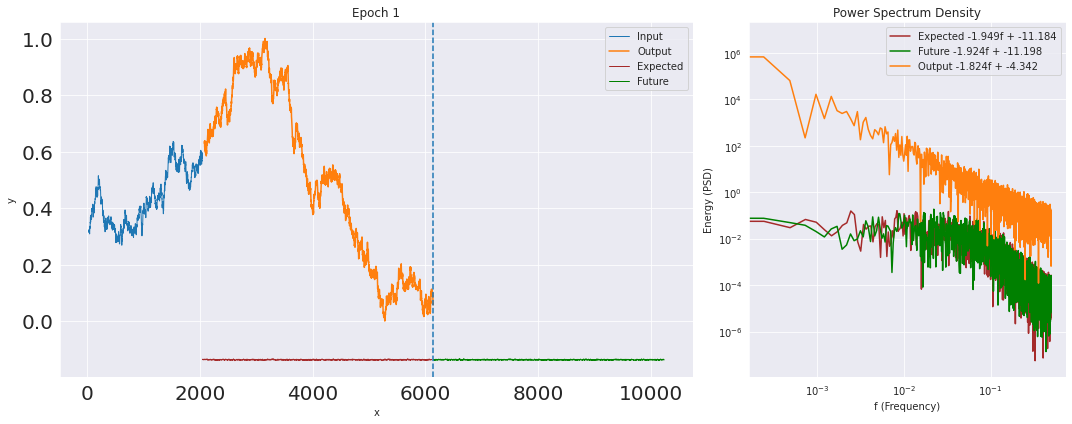

Step: 0, Loss: 0.009484928101301193


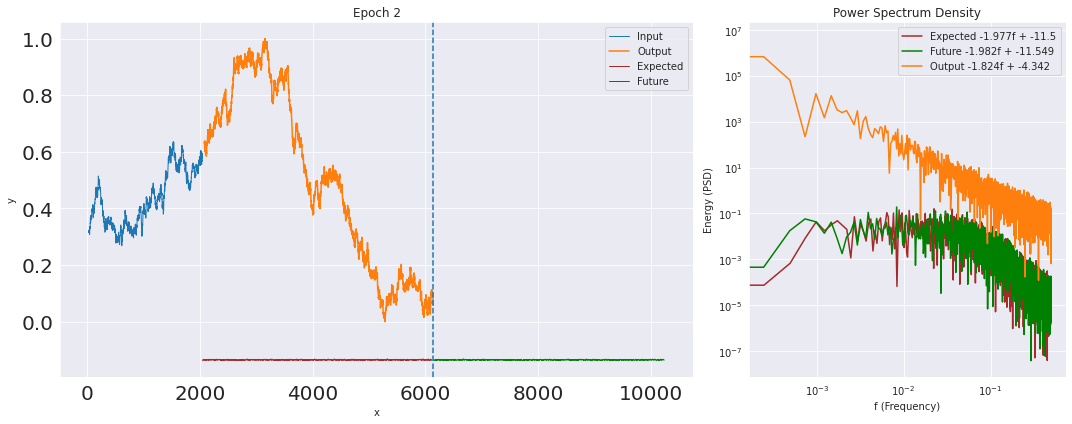

Step: 1, Loss: 0.019698336720466614


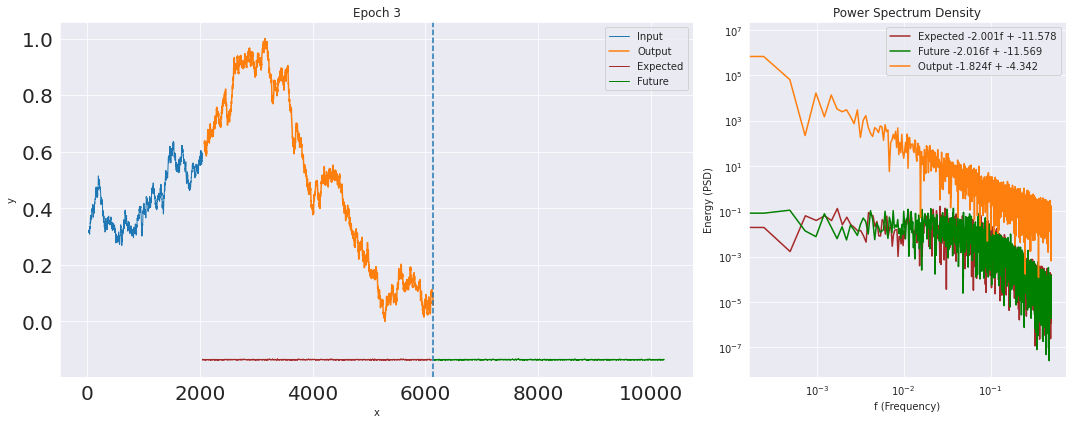

Step: 2, Loss: 0.007314940914511681


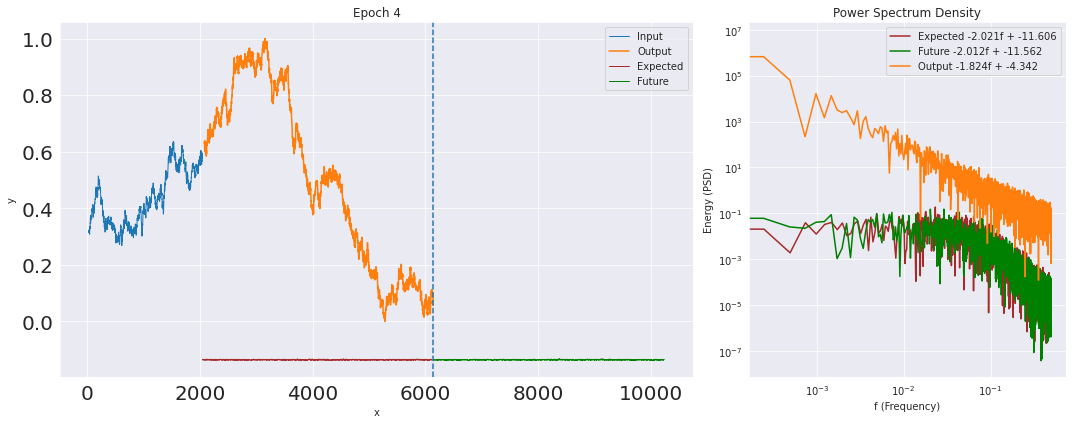

Step: 3, Loss: 0.013585325330495834


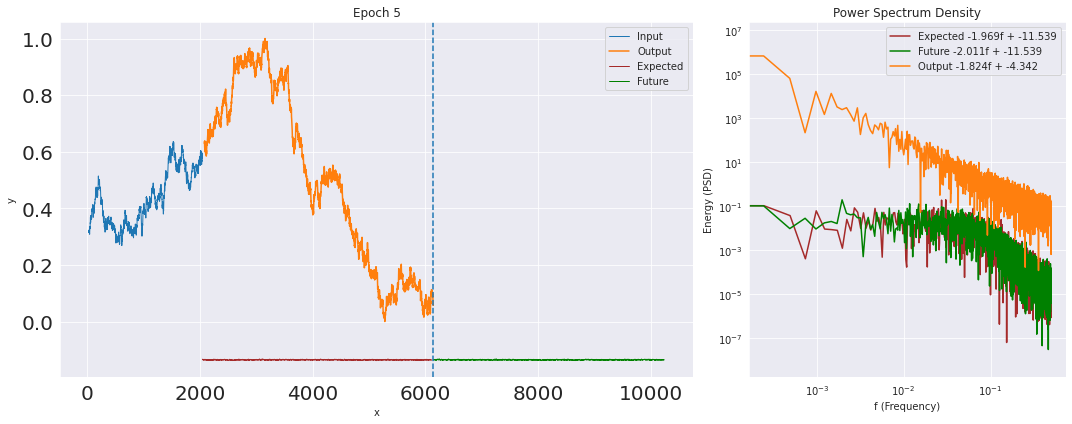

Step: 4, Loss: 0.020341161638498306


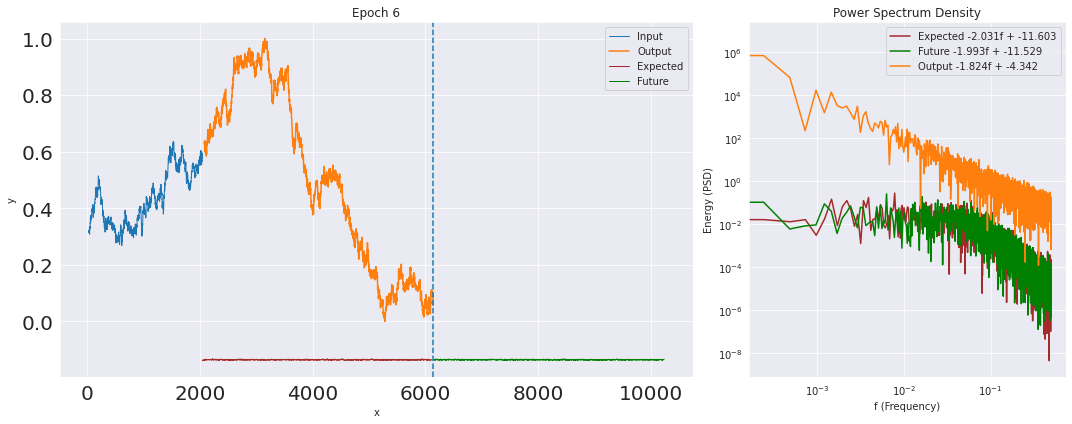

Step: 5, Loss: 0.02019750513136387


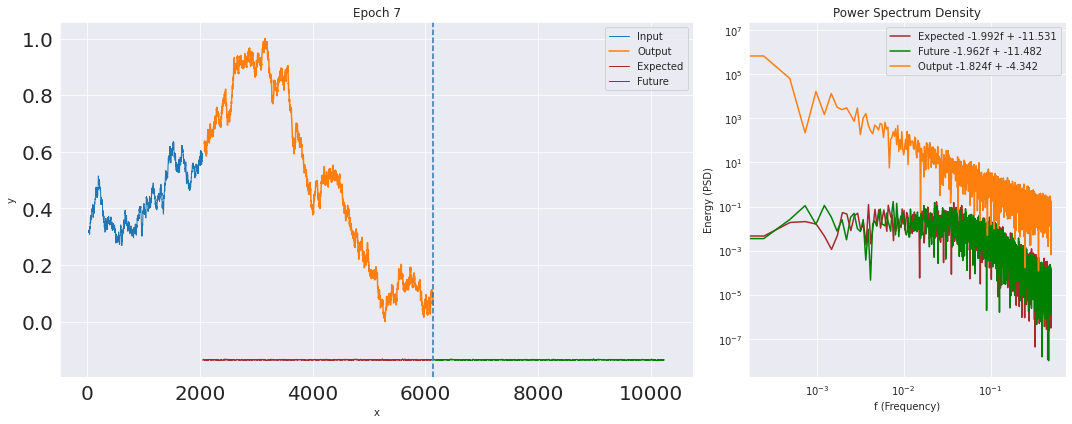

Step: 6, Loss: 0.011493882164359093


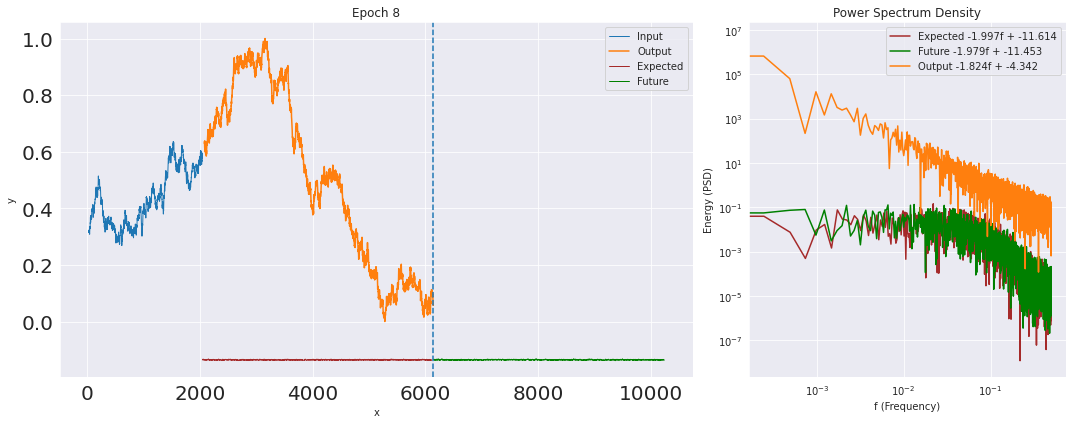

Step: 7, Loss: 0.009195255115628242


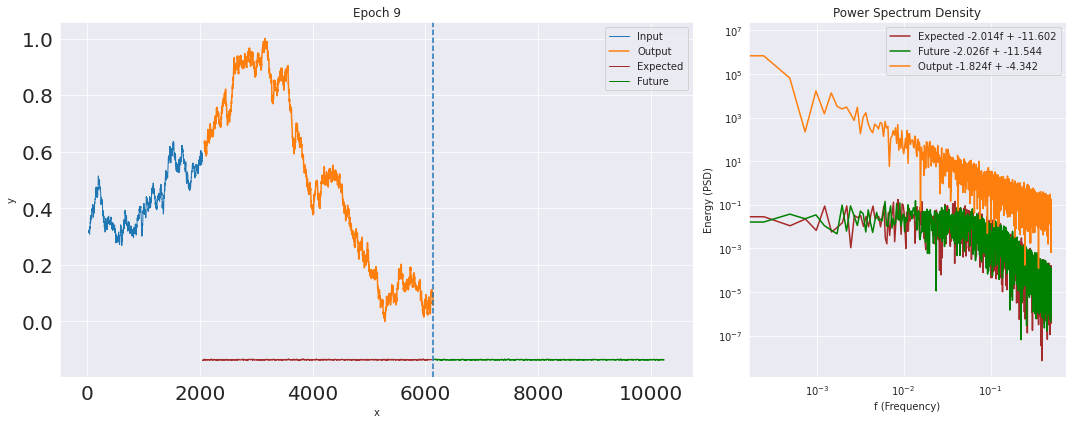

Step: 8, Loss: 0.02080569416284561


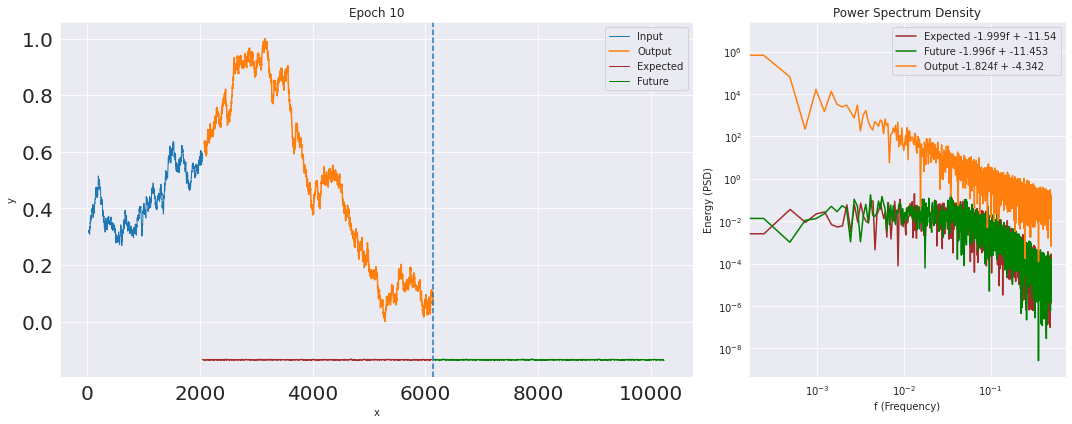

Step: 9, Loss: 0.011175168678164482


In [ ]:
#l = nn.MSELoss()
l = DBeta()

model = LSTM_ARMA()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
training_loop2(10, model, optimiser,l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]))

In [ ]:
def training_loop(n_epochs, model, optimiser, loss_fn,  train_input, train_target, test_input, test_target,future = 1024):
    train_input_clone = torch.clone(train_input)
    train_target_clone = torch.clone(train_target)
    for i in range(n_epochs):
        shuffle = torch.randperm(train_input_clone.size(0))
        train_input_clone = train_input_clone[shuffle,:]
        train_target_clone = train_target_clone[shuffle,:]
        
        def closure():
            optimiser.zero_grad()
            out = model(train_input_clone,train_target_clone.size(1)-train_input_clone.size(1))
            loss = loss_fn(out, train_target_clone)
            #print(loss,train_target,out)
            loss.backward()
            #print(list(model.parameters())[0].grad)
            return loss
        optimiser.step(closure)
        
        with torch.no_grad():
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 999
            #loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy().copy()
            
            #pred = model(test_input)
            # use all pred samples, but only go to 999
            #loss = loss_fn(pred, test_target)
            #y = pred.detach().numpy()
        
        # draw figures
        plt.figure(figsize=(15,6))
        gs = GridSpec(1,2,width_ratios=[2,1])
        
        plt.subplot(gs[0,0])
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(xi, yi,y_true, colour):
            #print(yi[32:n])
            plt.plot(np.arange(32,n), xi[32:n], color='b', linewidth=1.0)            
            plt.plot(np.arange(32,n), yi[32:n], colour, linewidth=1.0)
            plt.plot(np.arange(32,n), y_true[32:n],color='r')
            plt.plot(np.arange(n, n+future), yi[n:], colour, linewidth=1.0)
            plt.plot(yi[:], color='brown', linewidth=1.0)
            plt.axvline(n,ls='--')
        draw(train_input_clone[0],y[0],test_target[0], 'k')

        plt.subplot(gs[0,1])
        # calcula o PSD dos dados totais
        ft = np.fft.fft(y[0,test_input.size(1):])
        ft = np.real(ft*np.conj(ft))
        freq = np.fft.fftfreq(len(ft))
        seq = np.argsort(freq)
        a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
        #plota o psd
        plt.loglog(freq[seq],ft[seq],color='k')
        plt.xlabel("f (Frequency)")
        plt.ylabel("Energy (PSD)")
        if b>0.0:
          plt.title("Energy = {}f + {}".format(np.round(a,3),np.round(b,3)))
        else:
          plt.title("Energy = {}f {}".format(np.round(a,3),np.round(b,3)))
        plt.tight_layout()

        #plt.savefig("predict%d.png"%i, dpi=200)
        plt.show()
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        #for param in model.parameters():
        #  print(param.data)
        print("Step: {}, Loss: {}".format(i, loss_print))

## Teste da rede tradicional com ruído colorido

In [ ]:
def custom_mean_square_error(y_predictions, target):
  square_difference = torch.square(y_predictions - target)
  loss_value = torch.mean(square_difference)
  return loss_value

In [ ]:
class LSTM_teste(nn.Module):
    def __init__(self, hidden_size=32):
        super(LSTM_teste, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

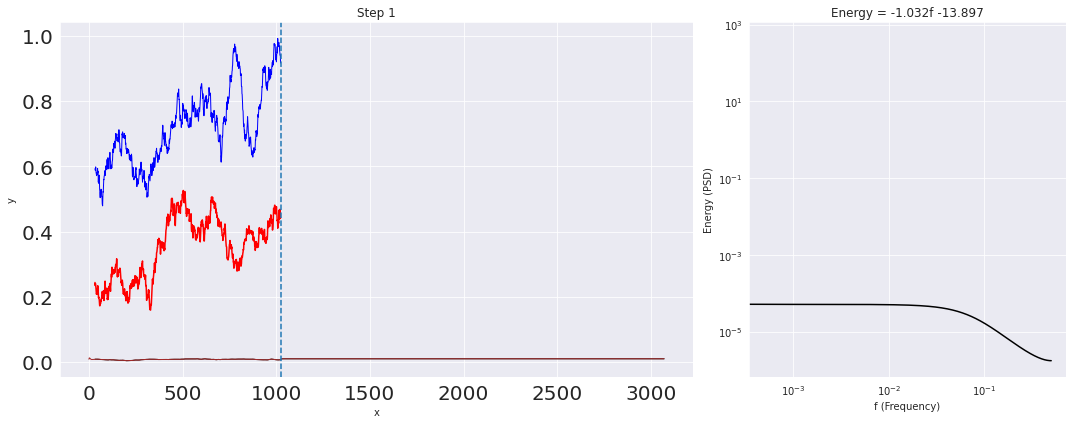

Step: 0, Loss: 0.5118141174316406


KeyboardInterrupt: ignored

In [ ]:
#l = nn.MSELoss()
l = DBeta()

model = LSTM()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
training_loop(10, model, optimiser,l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]))

# Modelo 2 - LSTM ARMA

A ideia dessa rede é evitar a dissonância informacional. A rede guarda internamente a memória de curto prazo, ao informar novamente a rede sobre o estado de curto prazo, poderemos estar reintroduzindo informação que já foi filtrada/descartada. Esta reintrodução de dado espúrio estamos chamando de dissonância informacional. 

In [ ]:
class LSTM_ARMA(nn.Module):
    def __init__(self, n_inputs=512, hidden_layers=32):
        super(LSTM_ARMA, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell( 1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(torch.rand(batch_size,1), (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            
            h_t, c_t = self.lstm1(torch.rand(batch_size,1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs


Refazendo o plot da função de treino, pois a do exemplo é muito ruim. Excluimos os 32 iniciais devido a arquitetura da rede, este é o tempo necessário para preencher a memória da primeira camada. 

## Teste com ruído vermelho

In [ ]:
win_in = 1024
win_ou = 1024
jump = 1024

dataset = rn
trainX, trainY, trainX_test,trainY_test = create_dataset2(dataset,win_in,win_ou,jump,isTensor=True)
#trainX, trainY, trainX_test, trainY_test = torch.tensor(trainX), torch.tensor(trainY), torch.tensor(trainX_test), torch.tensor(trainY_test)

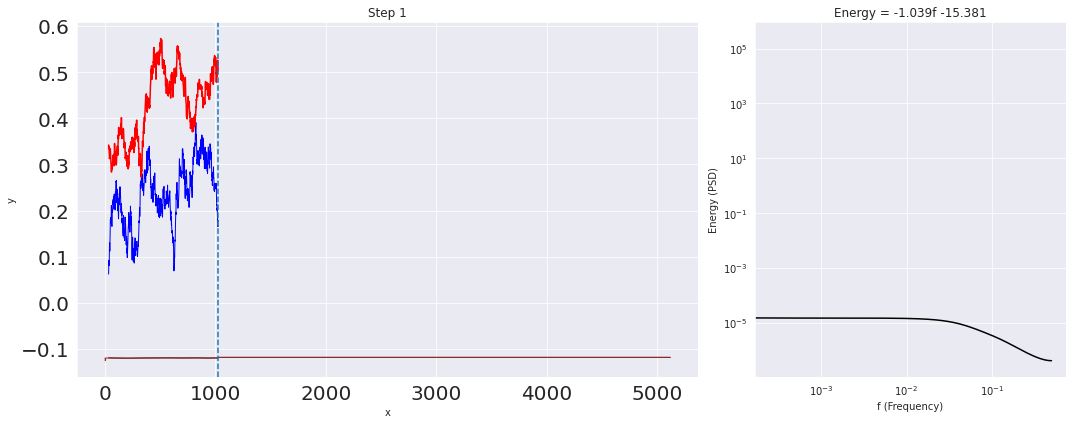

Step: 0, Loss: 0.23952314257621765


KeyboardInterrupt: ignored

In [ ]:
model = LSTM()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
l = DBeta()
training_loop(10, model, optimiser, l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]))

## Teste com ruido branco

In [ ]:
win_in = 1024
win_ou = 2**14
jump = 1024

dataset = wn
trainX, trainY, trainX_test,trainY_test = create_dataset2(dataset,win_in,win_ou,jump,isTensor=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
model = LSTM_ARMA()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
#l = DBeta_sigma()
training_loop(10, model, optimiser, l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]))

# MLP Model

In [ ]:
#l = DBeta_sigma()
l = DBeta()

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(self.input_size, self.hidden_size) 
        self.sigm = nn.Sigmoid()
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
   
    def forward(self, x):
        x2 = self.fc1(torch.rand(x.size(0),x.size(1)) )
        x2 = self.sigm(x2)
        x2 = self.fc2(x2)
        x2 = self.relu(x2)
        #x2 = self.dropout(x2)
        #x = self.fc2(x)
        return x2

    def __call__(self,x):
        x2 = self.fc1(torch.rand(x.size(0),x.size(1)))
        x2 = self.sigm(x2)
        x2 = self.fc2(x2)
        x2 = self.relu(x2)
        #x2 = self.dropout(x2)
        #x = self.fc2(x)
        return x2

def train_MLP(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = MLP(input_size, hidden_size, output_size)
    criterion = l#nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 20
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        print(f'Epochs = {i} Loss = {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss.detach().numpy())
            train_losses.append(loss.detach().numpy())
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model

NameError: ignored

Epochs = 0 Loss = 3.556627035140991
Epochs = 1 Loss = 2.06421160697937
Epochs = 2 Loss = 1.5062769651412964
Epochs = 3 Loss = 1.1346145868301392
Epochs = 4 Loss = 0.838694155216217
Epochs = 5 Loss = 0.7277509570121765
Epochs = 6 Loss = 0.6325720548629761
Epochs = 7 Loss = 0.5346094965934753
Epochs = 8 Loss = 0.4161180853843689
Epochs = 9 Loss = 0.29793301224708557
Epochs = 10 Loss = 0.23940302431583405
Epochs = 11 Loss = 0.19966159760951996
Epochs = 12 Loss = 0.15729254484176636
Epochs = 13 Loss = 0.11747279763221741
Epochs = 14 Loss = 0.09876666218042374
Epochs = 15 Loss = 0.07793135941028595
Epochs = 16 Loss = 0.0588265024125576
Epochs = 17 Loss = 0.041005928069353104
Epochs = 18 Loss = 0.03357323259115219
Epochs = 19 Loss = 0.02631976269185543


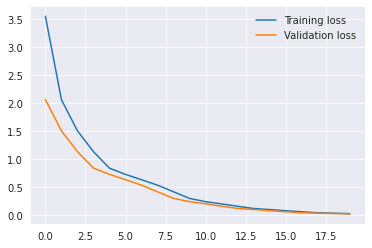

In [ ]:
model = train_MLP(trainX,trainY,trainX_test,trainY_test)

In [ ]:
targetX = model(trainX[0].resize(1,len(trainX[0])) )

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
print(l.beta(targetX.resize(1,len(targetX))))
print(l.beta(trainX[0].resize(1,len(trainX[0]))))
print(l.beta(trainY[0].resize(1,len(trainY[0]))))

RuntimeError: ignored

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


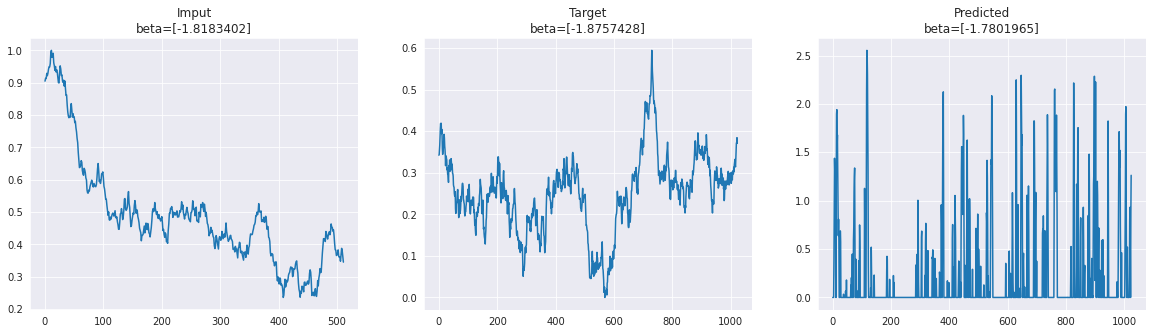

In [ ]:
j=10
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title(f'Imput\nbeta={l.beta(trainX[j].resize(1,len(trainX[j]))).detach().numpy()}')
plt.plot(trainX[j])
plt.subplot(1,3,2)
plt.title(f'Target\nbeta={l.beta(trainY[j].resize(1,len(trainY[j]))).detach().numpy()}')
plt.plot(trainY[j])
plt.subplot(1,3,3)
plt.title(f'Predicted\nbeta={l.beta(targetX).detach().numpy()}')
plt.plot(targetX.detach().numpy()[0])
plt.show()

In [ ]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[ 0.0325, -0.0051,  0.0154,  ...,  0.0284,  0.0118, -0.0132],
        [ 0.0215, -0.0210,  0.0301,  ...,  0.0416,  0.0174, -0.0169],
        [-0.0101,  0.0211,  0.0104,  ...,  0.0214,  0.0229, -0.0224],
        ...,
        [-0.0127, -0.0224, -0.0112,  ..., -0.0204, -0.0158, -0.0064],
        [ 0.0038, -0.0166, -0.0057,  ...,  0.0214, -0.0024,  0.0128],
        [ 0.0137, -0.0022, -0.0188,  ..., -0.0372,  0.0022, -0.0221]],
       requires_grad=True)
Parameter containing:
tensor([ 1.4457e-02,  3.5766e-02, -2.0623e-02, -4.0272e-02,  2.4046e-02,
        -5.5168e-03, -4.1227e-02,  2.1018e-02, -1.0287e-02, -2.0421e-02,
        -2.5223e-02,  7.5745e-03,  3.3798e-02,  1.7538e-02, -1.8533e-02,
        -1.1924e-02,  1.0143e-02,  3.5189e-03,  2.0762e-02, -2.8446e-02,
         4.8989e-03, -3.1437e-02, -2.8661e-02,  3.9429e-03,  1.1388e-02,
        -7.2460e-03,  1.8753e-02, -1.3310e-02,  1.9507e-02,  4.1287e-02,
         9.8250e-03, -7.2400e-03, -1.4258e-02, -2.6531e-0

# Other Models

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.gru = nn.GRU(self.input_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x)
        return x

#traing a GRU model using pytorch and trainX and trainY  

def train_GRU(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = GRU(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model



In [ ]:
#Create a RNN using pytorch, entering trainX and predicting trainY

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn = nn.RNN(self.input_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

def train_RNN(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = RNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model

In [ ]:


#Create a CNN using pytorch, entering trainX and predicting trainY

class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.conv1 = nn.Conv1d(self.input_size, self.hidden_size, 3)
        self.conv2 = nn.Conv1d(self.hidden_size, self.hidden_size, 3)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.fc(x)
        return x


def train_CNN(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = CNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model

In [ ]:
def train_GRU(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = GRU(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model

# Referencias 
[Copyright 2019, Rafael Ballester-Ripoll Revision 8c81a1cb.](https://tntorch.readthedocs.io/en/latest/_modules/metrics.html)

https://blog.paperspace.com/pytorch-loss-functions/

[LSTM and LSTMCell ？ - PyTorch Forums](https://discuss.pytorch.org/t/lstm-and-lstmcell/7488/5)